![Baseball Flights](baseball_flights.png)


To the Office of Transportation at The 22nd Century Sporting League,

After our inaugural 2101 season, The League is looking for ways to optimize our game scheduling process and costs.  We know that transportation logistics are a major variable to consider during scheduling, and as such, we’ve got a few questions for you. 

Our primary areas of focus are surrounding the number of jets that The League needs to own, and the cost of fuel for those flights. If we want The League to enjoy continued success, we'll need to make sure we manage transportation costs.

We’re sharing schedule data for the upcoming 2102 season.  On each row, you’ll find information about which teams are needing to travel to their next set of games, the time the flight will likely depart (based on our estimations of gameplay durations) and the time the flight will likely land. 

Additionally, we're also providing the fuel price that was paid each day during this past 2101 season. The fuel price fluctuates over time, but we're hoping you'll be able to project it to the future to help with the analysis.

We will answer the following questions to help The League optimize their flight schedules, keeping the important things to know in mind.

- We're interested in the maximum number of jets that The League needs to own. Create a time-series graph that shows how many teams will be “in flight” throughout the 2102 season. Use this graphic to tell us the maximum number of teams simultaneously in flight. Store these results in variables named max_teams_in_flight.

- Use 2101's jet fuel prices to project jet fuel prices for 2102. Apply these projections to every flight taken by every team to determine the overall fuel spend for 2102. Store your result in a variable named total_fuel_spend_2102_dollars.

## The Data

### team_flights.csv

| Column     | Description              |
|------------|--------------------------|
| `team_name` | Official team name |
| `departure_datetime` | Date and Time (in UTC) when the flight will depart |
| `landing_datetime` | Date and Time (in UTC) when the flight will land |


### fuel_price.csv

| Column     | Description              |
|------------|--------------------------|
| `date` | Date when the fuel price was recorded |
| `fuel_price` | Corresponding fuel price (in $ per gallon) |


### Important Things to Know
- You can assume that the flight's average speed is 500 MPH. (So, as an example, a 2-hour flight would travel 1000 miles)
- You can assume that each team’s jet fills up with fuel equivalent to 1 gallon per mile-of-travel 
- You can assume that the jet is fueled on the day the travel departs (and thus can use the fuel price corresponding to the departure date)

**Project Objective**

To analyze team flight data and fuel prices for the year 2101, and:
- Determine the maximum number of teams simultaneously flying (to plan fleet capacity).
- Forecast fuel prices for 2102 using time series modeling.
- Estimate the total projected fuel spend for 2102 by applying forecasted prices to scheduled team flights.

In [1]:
# Import required modules
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt


# Explore the data
team_flights = pd.read_csv('./team_flights.csv')
fuel_prices = pd.read_csv('./fuel_prices_2101.csv',
                         index_col='date')

team_flights.head()

# Some basic data cleaning and pre-processing
team_flights['departure_datetime'] = pd.to_datetime(team_flights['departure_datetime'])
team_flights['landing_datetime']   = pd.to_datetime(team_flights['landing_datetime'])

fuel_prices.index = pd.DatetimeIndex(fuel_prices.index).to_period('D')

# max_teams_in_flight 

First we'll want to know the minimum time between any two unique flight event times in the season

In [2]:
team_flights.head()

,team_name,departure_datetime,landing_datetime,travel_distance_miles
0,Agile Antelopes,2102-04-06 21:37:00,2102-04-07 00:35:57,1491.250000
1,Agile Antelopes,2102-04-10 23:57:00,2102-04-11 01:35:40,822.222222
2,Agile Antelopes,2102-04-14 00:29:00,2102-04-14 05:02:55,2282.638889
3,Agile Antelopes,2102-04-21 03:31:00,2102-04-21 05:23:09,934.583333
4,Agile Antelopes,2102-04-24 22:23:00,2102-04-25 00:25:50,1023.611111


In [3]:
# To do this we first create a single array of times
all_datetimes = pd.concat([team_flights['departure_datetime'], team_flights['landing_datetime']])

In [4]:
# Sort the array of datetimes
all_datetimes_sorted = sorted(list(set(all_datetimes)))
all_datetimes_sorted.append(pd.to_datetime('2102-04-01 00:00:00')) #optional
all_datetimes_sorted.append(pd.to_datetime('2102-10-05 00:00:00')) #optional

In [5]:
# convert to data frame
in_flight_df = pd.DataFrame({'date':sorted(all_datetimes_sorted),
                             'in_flight':0})
# iterate through each known flight, and increment corresponding rows of in_flight_df
for index, flight in team_flights.iterrows():
    in_flight_df.loc[(in_flight_df['date']>=flight['departure_datetime']) &
                     (in_flight_df['date']<flight['landing_datetime']),'in_flight'] += 1


In [6]:
in_flight_df.head()

,date,in_flight
0,2102-04-01 00:00:00,0
1,2102-04-03 21:40:00,2
2,2102-04-03 21:52:00,3
3,2102-04-03 22:02:00,4
4,2102-04-03 22:04:00,5


In [7]:
# Step 5: Find max number of teams in air
max_teams_in_flight = in_flight_df['in_flight'].max()
print("Maximum number of teams simultaneously in flight:", max_teams_in_flight)

Maximum number of teams simultaneously in flight: 19


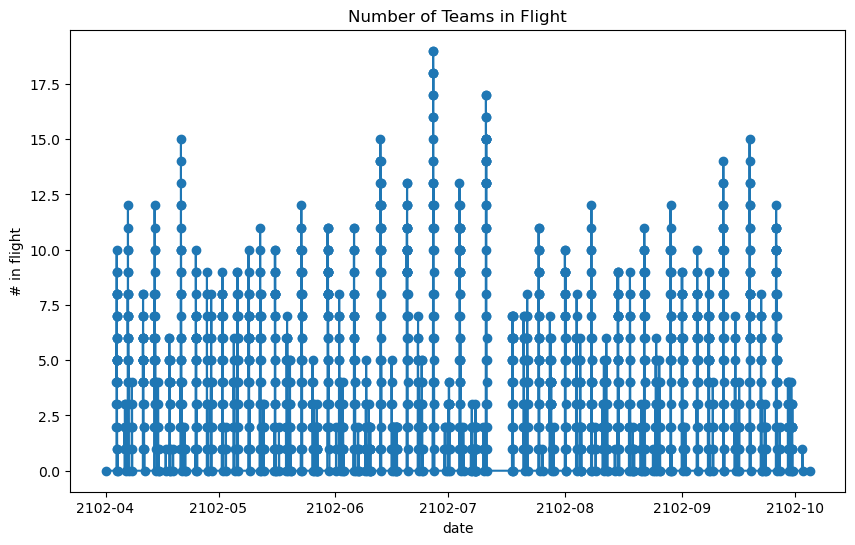

In [8]:
# Plot 
fig, ax = plt.subplots(figsize=(10, 6)) #optional size parameter
ax.step(in_flight_df['date'], in_flight_df['in_flight'], where='post') # optional
ax.scatter(in_flight_df['date'], in_flight_df['in_flight'])
ax.set_xlabel('date') # optional
ax.set_ylabel('# in flight') # optional
ax.set_title('Number of Teams in Flight') # optional
plt.show()

In [9]:
max_teams_in_flight = 19  # based on graph

#  total_fuel_spend_2102_dollars

In [10]:
fuel_prices.head()

,price
date,
2101-01-01,0.97
2101-01-02,0.87
2101-01-03,0.87
2101-01-04,0.97
2101-01-05,1.10


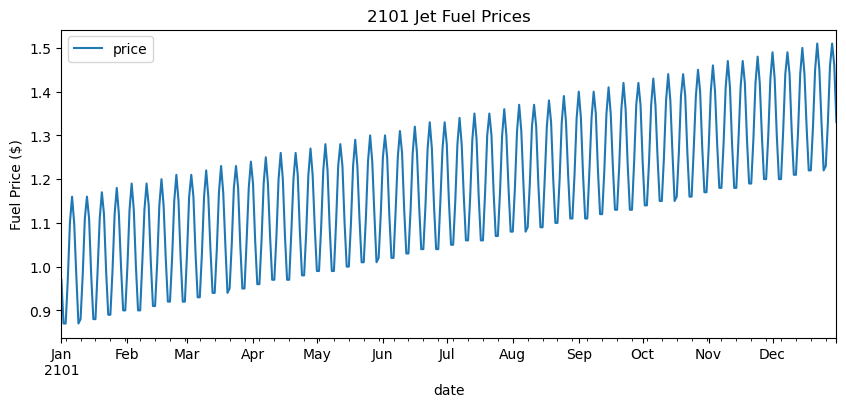

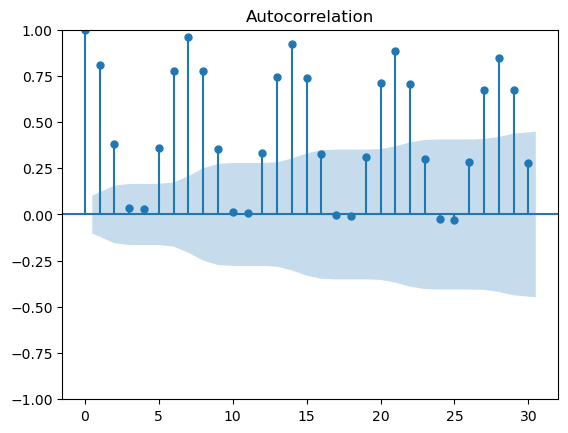

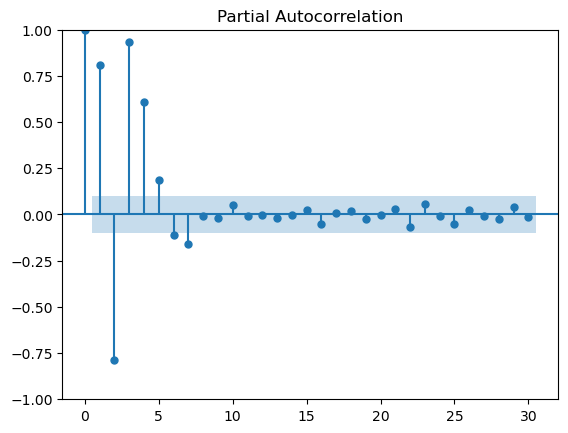

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Visualize trend and seasonality
fuel_prices.plot(figsize=(10,4), title="2101 Jet Fuel Prices", ylabel="Fuel Price ($)")
plt.show()

# Plot ACF and PACF
plot_acf(fuel_prices['price'], lags=30)
plt.show()

plot_pacf(fuel_prices['price'], lags=30)
plt.show()

We have observed a clear upward trend in the data, which suggests that we should use a differencing order of 1 (d = 1).

Additionally, there is a repeating weekly pattern. This is evident from the Autocorrelation Function (ACF) plot, where peaks occur at lags of 7, 14, and so on. Therefore, we should consider a seasonal differencing order of 1 (D = 1) with a seasonal period of 7 (s = 7).

Furthermore, the Partial Autocorrelation Function (PACF) plot shows significant spikes at lags 7 and non significant ones afterwards, confirming the weekly seasonality. This helps us determine the seasonal order (S).

In summary, our data exhibits both a trend and weekly seasonality.

**External Notes :**

- *detailed interpretations :*
    - Jet Fuel Price Plot:
The time series plot of 2101 jet fuel prices shows a clear upward trend and a repeating weekly pattern (seasonality). The prices increase over time, and there are regular oscillations, likely corresponding to weekly cycles.

    - ACF Plot:
The autocorrelation function (ACF) plot displays significant spikes at lags 7, 14, 21, etc., confirming strong weekly seasonality. The slow decay of autocorrelations also suggests non-stationarity due to the trend.

    - PACF Plot:
The partial autocorrelation function (PACF) plot shows significant spikes at lag 1 and lag 7, supporting the presence of both trend and weekly seasonality.
- *Conclusion:*
The series is non-stationary due to both trend and seasonality. Differencing (regular and seasonal) is needed before fitting ARIMA/SARIMA models.

*Aditionnal code* - doing differencing before fitting ARIMAX model and finding the order of the models 

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# # Regular differencing (d=1)
# fuel_prices_diff = fuel_prices['price'].diff().dropna()

# # Seasonal differencing (period=7, D=1)
# fuel_prices_seasonal_diff = fuel_prices['price'].diff(7).dropna()

# # Combined differencing (d=1, D=1, s=7) (two-step process)
fuel_prices_combined_diff = fuel_prices['price'].diff().diff(7).dropna()

In [ ]:
# Plot original and differenced series
fig, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
axs[0].plot(fuel_prices['price'])
axs[0].set_title('Original Series')
axs[1].plot(fuel_prices_diff)
axs[1].set_title('After Regular Differencing (d=1)')
axs[2].plot(fuel_prices_seasonal_diff)
axs[2].set_title('After Seasonal Differencing (D=1, s=7)')
axs[3].plot(fuel_prices_combined_diff)
axs[3].set_title('After Both Differencing (d=1, D=1, s=7)')
plt.tight_layout()
plt.show()

In [ ]:
# ADF Test function
def adf_test(series, title=''):
    result = adfuller(series.dropna())
    print(f'ADF Statistic for {title}: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    if result[1] < 0.05:
        print("Series is likely stationary.")
    else:
        print("Series is likely non-stationary.")

In [ ]:
# Run ADF tests
adf_test(fuel_prices['price'], 'Original')
adf_test(fuel_prices_diff, 'Regular Differenced')
adf_test(fuel_prices_seasonal_diff, 'Seasonal Differenced')
adf_test(fuel_prices_combined_diff, 'Both Differenced')

*Determine AR and MA Orders (p, q, P, Q)*
- ACF plot:
    - If ACF cuts off after lag q, suggests MA(q).
    - Seasonal spikes in ACF suggest seasonal MA (Q).
- PACF plot:
    - If PACF cuts off after lag p, suggests AR(p).
    - Seasonal spikes in PACF suggest seasonal AR (P).
  
*Case of Our Data*
- From your plots:
    - d=1 (trend), D=1 (seasonality), s=7 (weekly).
    - ACF: spikes at 7, 14, ... → Q=1
    - PACF: spikes at 1, 7 → p=1, P=1
- Typical starting order:
    - order=(1,1,1) and seasonal_order=(1,1,1,7)

In [23]:
# we'll need to project fuel prices into 2102
# then we'll apply them to our flight info
# Fit Seasonal ARIMA model
model = SARIMAX(fuel_prices,
              order=(1, 1, 1),             # for linear growth term
              seasonal_order=(1, 0, 0, 7)  # for 7 day periodicity
              )
model_fit = model.fit()
print(model_fit.summary())


                                     SARIMAX Results                                      
Dep. Variable:                              price   No. Observations:                  365
Model:             SARIMAX(1, 1, 1)x(1, 0, [], 7)   Log Likelihood                1414.372
Date:                            Sat, 24 May 2025   AIC                          -2820.744
Time:                                    11:44:50   BIC                          -2805.156
Sample:                                01-01-2101   HQIC                         -2814.549
                                     - 12-31-2101                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0107      0.054      0.197      0.844      -0.096       0.117
ma.L1         -0.9809      0.009   

In [13]:
# Forecast fuel prices for 2102
forecast = model_fit.get_forecast(steps=365)  # Forecast prices for 365 days in 2102

# Convert to Data Frame
fuel_prices_forecast = pd.DataFrame(data={"date": forecast.summary_frame().index.to_timestamp(), 
                                          "price":forecast.predicted_mean.values})

# Preview
fuel_prices_forecast.head()


,date,price
0,2102-01-01,1.227112
1,2102-01-02,1.237164
2,2102-01-03,1.336952
3,2102-01-04,1.466675
4,2102-01-05,1.516568


In [14]:
# Now we can apply to the flight data
# Step 1: Extract the date portion from the adjusted departure datetime
team_flights['departure_date'] = team_flights['departure_datetime'].dt.date


In [15]:
# Step 2: Join fuel_prices DataFrame based on the date
fuel_prices_forecast['date'] = fuel_prices_forecast['date'].dt.date
fuel_prices_forecast.set_index('date', inplace=True)
merged_df = team_flights.join(fuel_prices_forecast, on='departure_date', how='left')

In [16]:
# Step 3: Calculate the fuel cost for flights
# multiply price per mile
merged_df['fuel_cost_total'] = merged_df['price'] * merged_df['travel_distance_miles']

In [17]:
# Step 4: Calculate the overall fuel cost
total_fuel_spend_2102_dollars = merged_df['fuel_cost_total'].sum()
total_fuel_spend_2102_dollars

1859752.2989454702

## Project summary and main steps 

1. Data Preparation & Cleaning
- Read flight and fuel price datasets.
- Convert date columns to proper datetime/period formats for analysis and modeling.

2. Simultaneous Flight Tracking
- Combine departure and landing datetimes into a sorted timeline.
- For each flight, determine which timestamps it is in the air.
- Count how many flights are airborne at each timestamp → Plot and find the maximum simultaneous flights.

3. Fuel Price Forecasting
- Use SARIMAX model to handle both trend and weekly seasonality.
- Forecast daily fuel prices for 2102 (365 days) based on 2101's data.

4. Apply Fuel Prices to Flight Data
- Match each flight with its departure date.
- Join forecasted fuel prices on that date.
- Multiply distance by price to get flight cost → Sum to get total 2102 fuel spend

## Conclusion
Through this project, we were able to:

- Visualize team flight concurrency and identify peak resource demand (maximum planes needed).
- Build a seasonal time series model (SARIMAX) to forecast fuel prices realistically into the future.
- Apply these forecasts to scheduled flights to calculate a data-driven fuel budget for 2102.

***Outcome***: We now have both logistical insights (fleet demand) and financial planning estimates (fuel spend) for the upcoming travel season—all grounded in real data and predictive modeling.